In [1]:
#!/usr/bin/env python
# coding: utf-8
import pandas as pd
import os
import gc
import lightgbm as lgb
import xgboost as xgb
#from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.preprocessing import MinMaxScaler
import math
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')


train_df = pd.read_csv('../data/train/train.csv')
test_df = pd.read_csv('../data/test/test.csv')
sub = pd.DataFrame(test_df['time'])

train_df = train_df[train_df['temperature'].notnull()]
train_df = train_df.fillna(method='bfill')
test_df = test_df.fillna(method='bfill')
 
train_df.columns = ['time','year','month','day','hour','min','sec','outdoorTemp','outdoorHum',
                    'outdoorAtmo','indoorHum','indoorAtmo', 'temperature']
test_df.columns = ['time','year','month','day','hour','min','sec','outdoorTemp','outdoorHum',
                   'outdoorAtmo','indoorHum','indoorAtmo']


data_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# 基本聚合特征
group_feats = []
for f in tqdm(['outdoorTemp','outdoorHum','outdoorAtmo','indoorHum','indoorAtmo']):
    data_df['MDH_{}_medi'.format(f)] = data_df.groupby(['month','day','hour'])[f].transform('median')
    data_df['MDH_{}_mean'.format(f)] = data_df.groupby(['month','day','hour'])[f].transform('mean')
    data_df['MDH_{}_max'.format(f)] = data_df.groupby(['month','day','hour'])[f].transform('max')
    data_df['MDH_{}_min'.format(f)] = data_df.groupby(['month','day','hour'])[f].transform('min')
    data_df['MDH_{}_std'.format(f)] = data_df.groupby(['month','day','hour'])[f].transform('std')

    group_feats.append('MDH_{}_medi'.format(f))
    group_feats.append('MDH_{}_mean'.format(f))
    
# 基本交叉特征
for f1 in tqdm(['outdoorTemp','outdoorHum','outdoorAtmo','indoorHum','indoorAtmo']+group_feats):
    
    for f2 in ['outdoorTemp','outdoorHum','outdoorAtmo','indoorHum','indoorAtmo']+group_feats:
        if f1 != f2:
            colname = '{}_{}_ratio'.format(f1, f2)
            data_df[colname] = data_df[f1].values / data_df[f2].values

data_df = data_df.fillna(method='bfill')



# 历史信息提取
data_df['dt'] = data_df['day'].values + (data_df['month'].values - 3) * 31

for f in ['outdoorTemp','outdoorHum','outdoorAtmo','indoorHum','indoorAtmo', 'temperature']:
    tmp_df = pd.DataFrame()
    for t in tqdm(range(15, 45)):
        tmp = data_df[data_df['dt']<t].groupby(['hour'])[f].agg({'mean'}).reset_index()
        tmp.columns = ['hour','hit_{}_mean'.format(f)]
        tmp['dt'] = t
        tmp_df = tmp_df.append(tmp)
    
    data_df = data_df.merge(tmp_df, on=['dt','hour'], how='left')
    
data_df = data_df.fillna(method='bfill')


# 离散化
for f in ['outdoorTemp','outdoorHum','outdoorAtmo','indoorHum','indoorAtmo']:
    data_df[f+'_20_bin'] = pd.cut(data_df[f], 20, duplicates='drop').apply(lambda x:x.left).astype(int)
    data_df[f+'_50_bin'] = pd.cut(data_df[f], 50, duplicates='drop').apply(lambda x:x.left).astype(int)
    data_df[f+'_100_bin'] = pd.cut(data_df[f], 100, duplicates='drop').apply(lambda x:x.left).astype(int)
    data_df[f+'_200_bin'] = pd.cut(data_df[f], 200, duplicates='drop').apply(lambda x:x.left).astype(int)
    
for f1 in tqdm(['outdoorTemp_20_bin','outdoorHum_20_bin','outdoorAtmo_20_bin','indoorHum_20_bin','indoorAtmo_20_bin']):
    for f2 in ['outdoorTemp','outdoorHum','outdoorAtmo','indoorHum','indoorAtmo']:
        data_df['{}_{}_medi'.format(f1,f2)] = data_df.groupby([f1])[f2].transform('median')
        data_df['{}_{}_mean'.format(f1,f2)] = data_df.groupby([f1])[f2].transform('mean')
        data_df['{}_{}_max'.format(f1,f2)] = data_df.groupby([f1])[f2].transform('max')
        data_df['{}_{}_min'.format(f1,f2)] = data_df.groupby([f1])[f2].transform('min')
       
        
for f1 in tqdm(['outdoorTemp_50_bin','outdoorHum_50_bin','outdoorAtmo_50_bin','indoorHum_50_bin','indoorAtmo_50_bin']):
    for f2 in ['outdoorTemp','outdoorHum','outdoorAtmo','indoorHum','indoorAtmo']:
        data_df['{}_{}_medi'.format(f1,f2)] = data_df.groupby([f1])[f2].transform('median')
        data_df['{}_{}_mean'.format(f1,f2)] = data_df.groupby([f1])[f2].transform('mean')
        data_df['{}_{}_max'.format(f1,f2)] = data_df.groupby([f1])[f2].transform('max')
        data_df['{}_{}_min'.format(f1,f2)] = data_df.groupby([f1])[f2].transform('min')
        
for f1 in tqdm(['outdoorTemp_100_bin','outdoorHum_100_bin','outdoorAtmo_100_bin','indoorHum_100_bin','indoorAtmo_100_bin']):
    for f2 in ['outdoorTemp','outdoorHum','outdoorAtmo','indoorHum','indoorAtmo']:
        data_df['{}_{}_medi'.format(f1,f2)] = data_df.groupby([f1])[f2].transform('median')
        data_df['{}_{}_mean'.format(f1,f2)] = data_df.groupby([f1])[f2].transform('mean')
        data_df['{}_{}_max'.format(f1,f2)] = data_df.groupby([f1])[f2].transform('max')
        data_df['{}_{}_min'.format(f1,f2)] = data_df.groupby([f1])[f2].transform('min')
        
for f1 in tqdm(['outdoorTemp_200_bin','outdoorHum_200_bin','outdoorAtmo_200_bin','indoorHum_200_bin','indoorAtmo_200_bin']):
    for f2 in ['outdoorTemp','outdoorHum','outdoorAtmo','indoorHum','indoorAtmo']:
        data_df['{}_{}_medi'.format(f1,f2)] = data_df.groupby([f1])[f2].transform('median')
        data_df['{}_{}_mean'.format(f1,f2)] = data_df.groupby([f1])[f2].transform('mean')
        data_df['{}_{}_max'.format(f1,f2)] = data_df.groupby([f1])[f2].transform('max')
        data_df['{}_{}_min'.format(f1,f2)] = data_df.groupby([f1])[f2].transform('min')
        
drop_columns=["time","year","sec","temperature"]


train_count = train_df.shape[0]
train_df = data_df[:train_count].copy().reset_index(drop=True)
test_df = data_df[train_count:].copy().reset_index(drop=True)


features = train_df[:1].drop(drop_columns,axis=1).columns
x_train = train_df[features]
x_test = test_df[features]

y_train = train_df['temperature'].values - train_df['outdoorTemp'].values

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


In [2]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [5]:
def modelfit(alg,X_train,y_train,early_stopping_rounds=100):
    #xgb_param['num_class']=2
    xgb_param=alg.get_xgb_params()
    xgtrain=xgb.DMatrix(X_train,label=y_train)
    cvresult=xgb.cv(xgb_param,xgtrain,num_boost_round=alg.get_params()['n_estimators'],
                    metrics='mae',early_stopping_rounds=early_stopping_rounds,
                    verbose_eval=True)
    cvresult.to_csv('1_nestimators.csv',index_label='n_estimators')
    n_estimators=cvresult.shape[0]
    alg.set_params(n_estimators=n_estimators)
    alg.fit(X_train,y_train,eval_metric='mae')

In [21]:
model = xgb.XGBRegressor(
    booster = 'gbtree',
    learning_rate=0.1,
    n_estimators=10000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.3,
    colsample_bytree=0.8,
    colsample_bylevel=0.7,
    objective='reg:squarederror',
    seed=3)
modelfit(model,x_train,y_train)

[0]	train-mae:0.527902+0.0010499	test-mae:0.528037+0.00180731
[1]	train-mae:0.480751+0.000664383	test-mae:0.480947+0.00188113
[2]	train-mae:0.438835+0.000799654	test-mae:0.439041+0.00158163
[3]	train-mae:0.401546+0.00095482	test-mae:0.401818+0.00121742
[4]	train-mae:0.368239+0.000747	test-mae:0.368546+0.00147578
[5]	train-mae:0.338487+0.000629397	test-mae:0.338828+0.00138263
[6]	train-mae:0.31188+0.000508849	test-mae:0.3124+0.00151417
[7]	train-mae:0.288094+0.000536557	test-mae:0.288796+0.00125089
[8]	train-mae:0.267027+0.000414822	test-mae:0.26766+0.001085
[9]	train-mae:0.248192+0.000533144	test-mae:0.248879+0.00106686
[10]	train-mae:0.231182+0.000819502	test-mae:0.232215+0.00136463
[11]	train-mae:0.216322+0.000664346	test-mae:0.217599+0.00110929
[12]	train-mae:0.20336+0.000679218	test-mae:0.204895+0.000835163
[13]	train-mae:0.192109+0.000656666	test-mae:0.193871+0.00107641
[14]	train-mae:0.181816+0.000952363	test-mae:0.183832+0.000873383
[15]	train-mae:0.172885+0.000863525	test-mae:0

[125]	train-mae:0.0774977+0.000736648	test-mae:0.086801+0.00159752
[126]	train-mae:0.0772797+0.000806084	test-mae:0.0866503+0.001658
[127]	train-mae:0.0771237+0.000855999	test-mae:0.0865017+0.00166096
[128]	train-mae:0.0770203+0.000891432	test-mae:0.0864167+0.00169495
[129]	train-mae:0.0768533+0.000872401	test-mae:0.0862447+0.00163405
[130]	train-mae:0.07666+0.000801229	test-mae:0.0860557+0.00154459
[131]	train-mae:0.07644+0.000776804	test-mae:0.0858553+0.00150822
[132]	train-mae:0.0762713+0.000764053	test-mae:0.0857197+0.00147749
[133]	train-mae:0.0761247+0.00068209	test-mae:0.0856187+0.00140409
[134]	train-mae:0.076019+0.000642567	test-mae:0.0855567+0.00138816
[135]	train-mae:0.075823+0.000602043	test-mae:0.0854253+0.0013556
[136]	train-mae:0.07557+0.00059009	test-mae:0.0852113+0.00138218
[137]	train-mae:0.0754197+0.000539193	test-mae:0.0850813+0.00132318
[138]	train-mae:0.0753457+0.000565066	test-mae:0.0850227+0.00132794
[139]	train-mae:0.0751823+0.000593083	test-mae:0.0849133+0.001

[248]	train-mae:0.0631297+0.00043292	test-mae:0.075898+0.000919506
[249]	train-mae:0.063015+0.000418155	test-mae:0.0758263+0.000933681
[250]	train-mae:0.062937+0.000439752	test-mae:0.0757493+0.000903971
[251]	train-mae:0.0628403+0.000435584	test-mae:0.0757023+0.000928917
[252]	train-mae:0.0627837+0.000437348	test-mae:0.075668+0.000950726
[253]	train-mae:0.0626937+0.000386289	test-mae:0.075607+0.000923939
[254]	train-mae:0.0626043+0.00039157	test-mae:0.0755623+0.000917309
[255]	train-mae:0.062521+0.000382676	test-mae:0.075501+0.00093042
[256]	train-mae:0.0624577+0.000394415	test-mae:0.075453+0.000960057
[257]	train-mae:0.0623573+0.000371744	test-mae:0.075369+0.000945146
[258]	train-mae:0.0622597+0.000395072	test-mae:0.075287+0.000996083
[259]	train-mae:0.062208+0.000397334	test-mae:0.0752553+0.000991733
[260]	train-mae:0.0621557+0.000400501	test-mae:0.0752093+0.000978338
[261]	train-mae:0.062067+0.000398518	test-mae:0.0751683+0.000961503
[262]	train-mae:0.0620057+0.000387373	test-mae:0.

[369]	train-mae:0.054657+0.000262042	test-mae:0.070351+0.000795085
[370]	train-mae:0.0545957+0.000256791	test-mae:0.0703217+0.000786149
[371]	train-mae:0.054547+0.000260976	test-mae:0.0702723+0.000764039
[372]	train-mae:0.0544583+0.000249699	test-mae:0.0702+0.000770848
[373]	train-mae:0.054396+0.000268131	test-mae:0.0701603+0.000770591
[374]	train-mae:0.054329+0.000279331	test-mae:0.070118+0.000772631
[375]	train-mae:0.054249+0.000278061	test-mae:0.070059+0.000794442
[376]	train-mae:0.0542203+0.000288934	test-mae:0.0700393+0.000790938
[377]	train-mae:0.0541613+0.000289442	test-mae:0.0700077+0.000772158
[378]	train-mae:0.0541113+0.000308677	test-mae:0.0699753+0.000760804
[379]	train-mae:0.054086+0.000303411	test-mae:0.0699487+0.000755471
[380]	train-mae:0.0540243+0.000305752	test-mae:0.0699153+0.000765265
[381]	train-mae:0.053955+0.00031327	test-mae:0.0698607+0.000752575
[382]	train-mae:0.0538867+0.000301858	test-mae:0.06982+0.000737399
[383]	train-mae:0.0538363+0.000285204	test-mae:0.0

[490]	train-mae:0.048825+0.000416388	test-mae:0.066797+0.000741515
[491]	train-mae:0.0487807+0.000418779	test-mae:0.0667807+0.000751356
[492]	train-mae:0.0487363+0.000407138	test-mae:0.0667513+0.000716208
[493]	train-mae:0.04871+0.000401202	test-mae:0.0667477+0.000695043
[494]	train-mae:0.0486673+0.00038043	test-mae:0.066726+0.000705819
[495]	train-mae:0.0486333+0.000397091	test-mae:0.0667173+0.000701429
[496]	train-mae:0.0485867+0.000397751	test-mae:0.0666983+0.000710223
[497]	train-mae:0.0485417+0.000390651	test-mae:0.066676+0.000696136
[498]	train-mae:0.0484857+0.000383164	test-mae:0.0666377+0.000674524
[499]	train-mae:0.0484473+0.000377767	test-mae:0.0666107+0.000658479
[500]	train-mae:0.0484173+0.000379003	test-mae:0.0666067+0.000660293
[501]	train-mae:0.0483743+0.000360779	test-mae:0.0665567+0.000680359
[502]	train-mae:0.0483383+0.000362501	test-mae:0.0665397+0.000671295
[503]	train-mae:0.0482983+0.000374381	test-mae:0.066524+0.00067411
[504]	train-mae:0.0482307+0.000380821	test-

[611]	train-mae:0.044485+0.000339886	test-mae:0.0645803+0.000706456
[612]	train-mae:0.0444503+0.000338322	test-mae:0.0645527+0.000715054
[613]	train-mae:0.0444177+0.000341395	test-mae:0.0645333+0.000715728
[614]	train-mae:0.0443917+0.000345852	test-mae:0.064521+0.000712322
[615]	train-mae:0.04437+0.000349131	test-mae:0.064501+0.00069874
[616]	train-mae:0.0443403+0.000341472	test-mae:0.0644737+0.0006986
[617]	train-mae:0.044315+0.000352994	test-mae:0.064451+0.000704059
[618]	train-mae:0.0442793+0.000353294	test-mae:0.0644287+0.00071108
[619]	train-mae:0.044246+0.000352216	test-mae:0.0644023+0.000713228
[620]	train-mae:0.0442203+0.000349001	test-mae:0.0643947+0.000716636
[621]	train-mae:0.0441753+0.000342563	test-mae:0.0643743+0.000737113
[622]	train-mae:0.0441443+0.000357594	test-mae:0.064369+0.000726473
[623]	train-mae:0.0441187+0.000357562	test-mae:0.0643407+0.000717169
[624]	train-mae:0.0440967+0.000352626	test-mae:0.0643413+0.000723642
[625]	train-mae:0.044058+0.000338883	test-mae:0

[732]	train-mae:0.0409833+0.000304504	test-mae:0.062757+0.000762413
[733]	train-mae:0.0409497+0.000314453	test-mae:0.0627453+0.000756091
[734]	train-mae:0.040918+0.000314103	test-mae:0.0627243+0.000743967
[735]	train-mae:0.0408877+0.000323636	test-mae:0.0627133+0.000740065
[736]	train-mae:0.0408623+0.000333513	test-mae:0.0627083+0.000750157
[737]	train-mae:0.0408377+0.000337465	test-mae:0.0627107+0.000742851
[738]	train-mae:0.0408103+0.000335766	test-mae:0.062695+0.000738034
[739]	train-mae:0.040783+0.00034097	test-mae:0.062684+0.000732975
[740]	train-mae:0.0407523+0.000335504	test-mae:0.062677+0.000739192
[741]	train-mae:0.0407353+0.000330827	test-mae:0.0626657+0.000734326
[742]	train-mae:0.040717+0.000342527	test-mae:0.062658+0.00073383
[743]	train-mae:0.0406937+0.000343819	test-mae:0.0626577+0.000717626
[744]	train-mae:0.040671+0.000345338	test-mae:0.062637+0.000723634
[745]	train-mae:0.040654+0.000343699	test-mae:0.062633+0.000717797
[746]	train-mae:0.040636+0.000342013	test-mae:0.

[853]	train-mae:0.0380123+0.000323321	test-mae:0.0614513+0.000804715
[854]	train-mae:0.0379977+0.000334606	test-mae:0.0614383+0.000809812
[855]	train-mae:0.03797+0.000330539	test-mae:0.061416+0.000802093
[856]	train-mae:0.0379547+0.00032882	test-mae:0.0614077+0.000805189
[857]	train-mae:0.037939+0.000326987	test-mae:0.0614027+0.000802767
[858]	train-mae:0.0379133+0.000332715	test-mae:0.06138+0.00079947
[859]	train-mae:0.037899+0.00033102	test-mae:0.0613713+0.000797316
[860]	train-mae:0.03788+0.000324753	test-mae:0.0613677+0.000799217
[861]	train-mae:0.037849+0.000331096	test-mae:0.0613407+0.000788994
[862]	train-mae:0.0378277+0.000334318	test-mae:0.0613253+0.000785611
[863]	train-mae:0.0378007+0.000333025	test-mae:0.0613267+0.000776059
[864]	train-mae:0.0377717+0.00033598	test-mae:0.0613127+0.000776516
[865]	train-mae:0.037753+0.000337794	test-mae:0.061298+0.000773271
[866]	train-mae:0.0377297+0.000333163	test-mae:0.061283+0.000757735
[867]	train-mae:0.037714+0.000327482	test-mae:0.061

[974]	train-mae:0.0355027+0.000352865	test-mae:0.0603427+0.000796724
[975]	train-mae:0.0354913+0.000359047	test-mae:0.060327+0.000804018
[976]	train-mae:0.0354707+0.000352252	test-mae:0.0603323+0.000817124
[977]	train-mae:0.035452+0.000353	test-mae:0.06032+0.000811409
[978]	train-mae:0.0354257+0.000354125	test-mae:0.0603133+0.000806722
[979]	train-mae:0.035404+0.000348018	test-mae:0.0603023+0.000803569
[980]	train-mae:0.035378+0.000338604	test-mae:0.060303+0.000802928
[981]	train-mae:0.0353583+0.000343738	test-mae:0.060292+0.000802079
[982]	train-mae:0.0353447+0.000348125	test-mae:0.0602937+0.000813109
[983]	train-mae:0.0353287+0.000338315	test-mae:0.0602847+0.000817445
[984]	train-mae:0.0353177+0.000338016	test-mae:0.0602777+0.000812529
[985]	train-mae:0.0352983+0.000335466	test-mae:0.06026+0.000795727
[986]	train-mae:0.0352783+0.000333331	test-mae:0.0602457+0.000804662
[987]	train-mae:0.0352613+0.000332315	test-mae:0.060241+0.000797298
[988]	train-mae:0.035242+0.000323175	test-mae:0.

[1094]	train-mae:0.0334063+0.000277832	test-mae:0.0594317+0.00076481
[1095]	train-mae:0.0333913+0.000274754	test-mae:0.059419+0.000768876
[1096]	train-mae:0.0333823+0.000274008	test-mae:0.0594143+0.000765206
[1097]	train-mae:0.0333637+0.000276044	test-mae:0.0594103+0.000754896
[1098]	train-mae:0.033348+0.000281007	test-mae:0.059404+0.000750973
[1099]	train-mae:0.03334+0.000288759	test-mae:0.059401+0.000747236
[1100]	train-mae:0.033328+0.000293758	test-mae:0.059401+0.000752518
[1101]	train-mae:0.0333123+0.000289558	test-mae:0.0593953+0.000754514
[1102]	train-mae:0.033294+0.000285682	test-mae:0.059382+0.000759883
[1103]	train-mae:0.0332827+0.000287561	test-mae:0.059375+0.00076484
[1104]	train-mae:0.0332673+0.000281101	test-mae:0.0593667+0.000766665
[1105]	train-mae:0.0332513+0.000283843	test-mae:0.0593637+0.000767179
[1106]	train-mae:0.0332327+0.000288329	test-mae:0.059355+0.000766735
[1107]	train-mae:0.0332157+0.000302428	test-mae:0.0593497+0.000765795
[1108]	train-mae:0.033191+0.000290

[1213]	train-mae:0.0316207+0.000248503	test-mae:0.0587587+0.000806648
[1214]	train-mae:0.0316017+0.000245386	test-mae:0.0587513+0.00079913
[1215]	train-mae:0.0315923+0.000247259	test-mae:0.0587483+0.000798083
[1216]	train-mae:0.0315843+0.000243142	test-mae:0.0587533+0.000802237
[1217]	train-mae:0.0315737+0.000238464	test-mae:0.0587603+0.000809203
[1218]	train-mae:0.0315597+0.00023696	test-mae:0.0587543+0.000810593
[1219]	train-mae:0.031544+0.000236695	test-mae:0.058735+0.000811818
[1220]	train-mae:0.0315223+0.000240141	test-mae:0.0587253+0.000810655
[1221]	train-mae:0.0315093+0.000236144	test-mae:0.058727+0.00080695
[1222]	train-mae:0.031499+0.000237345	test-mae:0.058717+0.000800705
[1223]	train-mae:0.031488+0.000241762	test-mae:0.0587103+0.000805097
[1224]	train-mae:0.031477+0.000238098	test-mae:0.0587107+0.000811649
[1225]	train-mae:0.031465+0.000236301	test-mae:0.0587087+0.00080955
[1226]	train-mae:0.0314533+0.000241276	test-mae:0.0587057+0.000802424
[1227]	train-mae:0.0314393+0.000

[1332]	train-mae:0.0300893+0.000279884	test-mae:0.058283+0.000826872
[1333]	train-mae:0.030072+0.000280419	test-mae:0.058283+0.000825788
[1334]	train-mae:0.0300667+0.000275707	test-mae:0.058269+0.000825054
[1335]	train-mae:0.030058+0.000271151	test-mae:0.058266+0.000832339
[1336]	train-mae:0.0300433+0.000266246	test-mae:0.0582553+0.000834197
[1337]	train-mae:0.030035+0.0002683	test-mae:0.05825+0.000827679
[1338]	train-mae:0.0300283+0.000274933	test-mae:0.0582443+0.000823406
[1339]	train-mae:0.030009+0.000275921	test-mae:0.058242+0.000827256
[1340]	train-mae:0.029999+0.000273354	test-mae:0.0582367+0.000826146
[1341]	train-mae:0.0299843+0.000270647	test-mae:0.05822+0.000831998
[1342]	train-mae:0.0299717+0.000273996	test-mae:0.0582093+0.000824423
[1343]	train-mae:0.0299527+0.000268951	test-mae:0.058213+0.000825163
[1344]	train-mae:0.0299437+0.000266108	test-mae:0.0582117+0.000824058
[1345]	train-mae:0.0299273+0.000267271	test-mae:0.0582067+0.000829283
[1346]	train-mae:0.0299093+0.00027281

[1451]	train-mae:0.028781+0.000258481	test-mae:0.0579163+0.000912507
[1452]	train-mae:0.028773+0.000257217	test-mae:0.0579277+0.000907805
[1453]	train-mae:0.028772+0.000258152	test-mae:0.0579293+0.000906641
[1454]	train-mae:0.028765+0.000254939	test-mae:0.0579313+0.00091595
[1455]	train-mae:0.0287497+0.000257907	test-mae:0.0579253+0.000915107
[1456]	train-mae:0.0287373+0.000257425	test-mae:0.057921+0.000912536
[1457]	train-mae:0.028725+0.000257585	test-mae:0.0579093+0.000908624
[1458]	train-mae:0.0287183+0.000252022	test-mae:0.057896+0.000910721
[1459]	train-mae:0.0287083+0.000251338	test-mae:0.0578923+0.000910088
[1460]	train-mae:0.0286993+0.000250964	test-mae:0.0578813+0.000911662
[1461]	train-mae:0.028689+0.000249881	test-mae:0.0578757+0.000916048
[1462]	train-mae:0.028679+0.000249609	test-mae:0.057873+0.000909147
[1463]	train-mae:0.0286733+0.000249488	test-mae:0.0578697+0.000903136
[1464]	train-mae:0.0286687+0.00024946	test-mae:0.0578597+0.000914478
[1465]	train-mae:0.028655+0.0002

[1570]	train-mae:0.0275353+0.000221742	test-mae:0.057568+0.000936301
[1571]	train-mae:0.0275237+0.000222642	test-mae:0.05756+0.000935393
[1572]	train-mae:0.0275157+0.000217895	test-mae:0.057554+0.000938489
[1573]	train-mae:0.0275037+0.000219837	test-mae:0.057552+0.000939762
[1574]	train-mae:0.0274897+0.000214682	test-mae:0.0575547+0.000941556
[1575]	train-mae:0.0274797+0.000212406	test-mae:0.05755+0.000939266
[1576]	train-mae:0.0274703+0.000212581	test-mae:0.0575417+0.000941503
[1577]	train-mae:0.027454+0.000216547	test-mae:0.0575343+0.000946103
[1578]	train-mae:0.027449+0.000215431	test-mae:0.057527+0.000954573
[1579]	train-mae:0.0274443+0.000214088	test-mae:0.057524+0.00095756
[1580]	train-mae:0.0274293+0.000217773	test-mae:0.057519+0.000960611
[1581]	train-mae:0.027423+0.000216543	test-mae:0.0575043+0.000962516
[1582]	train-mae:0.0274103+0.000223476	test-mae:0.0574993+0.000959588
[1583]	train-mae:0.0273993+0.000225343	test-mae:0.057499+0.000958349
[1584]	train-mae:0.027389+0.0002242

[1690]	train-mae:0.026436+0.000182128	test-mae:0.057304+0.000994192
[1691]	train-mae:0.026427+0.000186097	test-mae:0.0573047+0.000994038
[1692]	train-mae:0.0264203+0.000187057	test-mae:0.0573047+0.000997763
[1693]	train-mae:0.0264093+0.000192266	test-mae:0.057301+0.000996893
[1694]	train-mae:0.026401+0.000195225	test-mae:0.057295+0.00100521
[1695]	train-mae:0.0263977+0.000192067	test-mae:0.0572933+0.00100417
[1696]	train-mae:0.026393+0.000191527	test-mae:0.0572967+0.00101649
[1697]	train-mae:0.0263857+0.000195259	test-mae:0.057295+0.00101146
[1698]	train-mae:0.026376+0.000193455	test-mae:0.057293+0.00100182
[1699]	train-mae:0.0263663+0.000192302	test-mae:0.057293+0.00100773
[1700]	train-mae:0.0263623+0.000192751	test-mae:0.057297+0.0010126
[1701]	train-mae:0.026351+0.00019482	test-mae:0.0573017+0.00100044
[1702]	train-mae:0.02634+0.000198556	test-mae:0.0572993+0.00100177
[1703]	train-mae:0.026332+0.000199125	test-mae:0.0572983+0.00100325
[1704]	train-mae:0.0263203+0.000202322	test-mae:

[1810]	train-mae:0.025444+0.000215291	test-mae:0.0570403+0.00100831
[1811]	train-mae:0.025438+0.000216154	test-mae:0.0570407+0.00101055
[1812]	train-mae:0.0254307+0.000218379	test-mae:0.057034+0.00101072
[1813]	train-mae:0.0254207+0.000221796	test-mae:0.0570277+0.00101248
[1814]	train-mae:0.0254123+0.000228328	test-mae:0.057023+0.00101429
[1815]	train-mae:0.0254037+0.000226113	test-mae:0.0570163+0.00101446
[1816]	train-mae:0.0253987+0.000222295	test-mae:0.0570143+0.00101381
[1817]	train-mae:0.0253947+0.000221157	test-mae:0.0570173+0.00101014
[1818]	train-mae:0.0253803+0.000227676	test-mae:0.0570043+0.00100811
[1819]	train-mae:0.0253733+0.000227948	test-mae:0.057005+0.00100331
[1820]	train-mae:0.0253617+0.000232352	test-mae:0.0570053+0.00100099
[1821]	train-mae:0.025352+0.000230332	test-mae:0.0570007+0.00100459
[1822]	train-mae:0.025346+0.000230777	test-mae:0.0570017+0.000999434
[1823]	train-mae:0.02534+0.000225703	test-mae:0.057002+0.00100126
[1824]	train-mae:0.0253317+0.000228516	test

[1931]	train-mae:0.0244813+0.000212378	test-mae:0.056841+0.00100403
[1932]	train-mae:0.024475+0.000216381	test-mae:0.056834+0.000998864
[1933]	train-mae:0.0244683+0.000218398	test-mae:0.0568273+0.00100411
[1934]	train-mae:0.0244603+0.000217589	test-mae:0.0568303+0.00100217
[1935]	train-mae:0.024456+0.00021941	test-mae:0.056829+0.00100975
[1936]	train-mae:0.0244473+0.000214576	test-mae:0.0568283+0.00100681
[1937]	train-mae:0.024436+0.00021336	test-mae:0.0568263+0.00100659
[1938]	train-mae:0.024432+0.000213274	test-mae:0.056827+0.00101007
[1939]	train-mae:0.0244287+0.000213551	test-mae:0.0568197+0.00100924
[1940]	train-mae:0.0244203+0.000216164	test-mae:0.056815+0.00101019
[1941]	train-mae:0.02441+0.000215427	test-mae:0.0568153+0.00100716
[1942]	train-mae:0.024402+0.000216006	test-mae:0.0568133+0.00100411
[1943]	train-mae:0.0243963+0.000217388	test-mae:0.0568073+0.00100826
[1944]	train-mae:0.0243923+0.000216475	test-mae:0.0568103+0.00100562
[1945]	train-mae:0.0243867+0.000217771	test-mae

[2051]	train-mae:0.0236647+0.000223124	test-mae:0.0566507+0.000981633
[2052]	train-mae:0.0236537+0.000215617	test-mae:0.0566497+0.000983538
[2053]	train-mae:0.023648+0.0002184	test-mae:0.0566463+0.000983898
[2054]	train-mae:0.0236427+0.000221315	test-mae:0.0566393+0.000979832
[2055]	train-mae:0.0236383+0.000220844	test-mae:0.0566387+0.000980153
[2056]	train-mae:0.023633+0.000224557	test-mae:0.056638+0.000986912
[2057]	train-mae:0.0236253+0.000221474	test-mae:0.0566353+0.000993377
[2058]	train-mae:0.0236163+0.000225621	test-mae:0.0566367+0.000993359
[2059]	train-mae:0.023607+0.000221641	test-mae:0.0566433+0.000991175
[2060]	train-mae:0.023598+0.000224385	test-mae:0.056645+0.000990003
[2061]	train-mae:0.0235947+0.000225327	test-mae:0.056648+0.00098907
[2062]	train-mae:0.0235887+0.000226554	test-mae:0.056654+0.000985672
[2063]	train-mae:0.0235813+0.000226798	test-mae:0.056652+0.000989121
[2064]	train-mae:0.0235713+0.000228911	test-mae:0.0566517+0.000987553
[2065]	train-mae:0.023563+0.0002

[2170]	train-mae:0.0228767+0.000229658	test-mae:0.0564887+0.000948308
[2171]	train-mae:0.0228717+0.00023031	test-mae:0.0564897+0.000948032
[2172]	train-mae:0.0228643+0.00023576	test-mae:0.0564833+0.000948656
[2173]	train-mae:0.0228577+0.000232273	test-mae:0.0564833+0.000950344
[2174]	train-mae:0.0228523+0.000230792	test-mae:0.0564813+0.000946028
[2175]	train-mae:0.0228477+0.000226295	test-mae:0.0564827+0.000945037
[2176]	train-mae:0.0228407+0.000225722	test-mae:0.0564863+0.000942704
[2177]	train-mae:0.0228387+0.000226381	test-mae:0.0564833+0.000942012
[2178]	train-mae:0.022835+0.00022801	test-mae:0.056482+0.000946126
[2179]	train-mae:0.02283+0.000229939	test-mae:0.056478+0.000947325
[2180]	train-mae:0.0228237+0.000232712	test-mae:0.0564687+0.000949004
[2181]	train-mae:0.022817+0.000233077	test-mae:0.056473+0.000950465
[2182]	train-mae:0.0228097+0.000229157	test-mae:0.0564713+0.000954824
[2183]	train-mae:0.0227997+0.000231618	test-mae:0.056473+0.000954139
[2184]	train-mae:0.0227963+0.00

[2289]	train-mae:0.0221573+0.000200367	test-mae:0.0563197+0.00102682
[2290]	train-mae:0.0221517+0.0002002	test-mae:0.0563127+0.00102726
[2291]	train-mae:0.0221423+0.00020015	test-mae:0.0563117+0.0010238
[2292]	train-mae:0.0221333+0.000205227	test-mae:0.0563133+0.00102783
[2293]	train-mae:0.0221307+0.000204303	test-mae:0.0563153+0.0010218
[2294]	train-mae:0.0221283+0.000205388	test-mae:0.0563217+0.00101765
[2295]	train-mae:0.0221183+0.000204915	test-mae:0.0563183+0.00101747
[2296]	train-mae:0.0221177+0.00020369	test-mae:0.0563133+0.00101402
[2297]	train-mae:0.0221087+0.000203989	test-mae:0.0563033+0.00101707
[2298]	train-mae:0.0221023+0.000204614	test-mae:0.056305+0.00101213
[2299]	train-mae:0.022095+0.000203531	test-mae:0.0563043+0.00100458
[2300]	train-mae:0.0220927+0.000206814	test-mae:0.0562983+0.00100768
[2301]	train-mae:0.0220857+0.000202919	test-mae:0.0562943+0.00101113
[2302]	train-mae:0.0220823+0.000203847	test-mae:0.0562903+0.00100541
[2303]	train-mae:0.0220793+0.000206489	tes

[2410]	train-mae:0.0214993+0.000206544	test-mae:0.056203+0.00103969
[2411]	train-mae:0.0214953+0.000204837	test-mae:0.056208+0.00104162
[2412]	train-mae:0.0214863+0.000205965	test-mae:0.056212+0.00104051
[2413]	train-mae:0.0214847+0.0002033	test-mae:0.0562097+0.00104488
[2414]	train-mae:0.0214783+0.000202322	test-mae:0.0562093+0.001038
[2415]	train-mae:0.0214727+0.000200723	test-mae:0.0562157+0.00103275
[2416]	train-mae:0.021466+0.000200365	test-mae:0.056212+0.00103282
[2417]	train-mae:0.0214623+0.000200915	test-mae:0.0562123+0.00103497
[2418]	train-mae:0.021457+0.000199544	test-mae:0.056211+0.00103544
[2419]	train-mae:0.0214507+0.000199742	test-mae:0.0562083+0.0010401
[2420]	train-mae:0.0214453+0.000202406	test-mae:0.056203+0.00104357
[2421]	train-mae:0.0214427+0.000199896	test-mae:0.056199+0.00104713
[2422]	train-mae:0.0214373+0.000199025	test-mae:0.0562017+0.00105282
[2423]	train-mae:0.0214283+0.000197714	test-mae:0.0561997+0.00105235
[2424]	train-mae:0.0214217+0.000195374	test-mae:

[2531]	train-mae:0.020865+0.000196313	test-mae:0.0560853+0.00107994
[2532]	train-mae:0.0208613+0.000195288	test-mae:0.0560817+0.00108604
[2533]	train-mae:0.02086+0.000197471	test-mae:0.056079+0.00108739
[2534]	train-mae:0.0208547+0.000197001	test-mae:0.0560747+0.00108358
[2535]	train-mae:0.020849+0.000198378	test-mae:0.05608+0.00108233
[2536]	train-mae:0.0208447+0.000198745	test-mae:0.0560793+0.00108347
[2537]	train-mae:0.0208437+0.000198933	test-mae:0.05607+0.00108417
[2538]	train-mae:0.020838+0.000202511	test-mae:0.0560737+0.00108332
[2539]	train-mae:0.020833+0.000202864	test-mae:0.0560773+0.0010907
[2540]	train-mae:0.0208283+0.000204381	test-mae:0.0560713+0.00109371
[2541]	train-mae:0.020825+0.000203058	test-mae:0.0560673+0.00109308
[2542]	train-mae:0.0208213+0.000199109	test-mae:0.056069+0.00109321
[2543]	train-mae:0.0208153+0.000198208	test-mae:0.05607+0.00109623
[2544]	train-mae:0.020811+0.000194321	test-mae:0.056076+0.00109483
[2545]	train-mae:0.0208053+0.000194296	test-mae:0.05

[2652]	train-mae:0.0202877+0.000179852	test-mae:0.0559787+0.00110576
[2653]	train-mae:0.0202823+0.000179426	test-mae:0.0559747+0.00110414
[2654]	train-mae:0.020274+0.000179652	test-mae:0.0559727+0.00109778
[2655]	train-mae:0.0202687+0.000180614	test-mae:0.0559723+0.00109814
[2656]	train-mae:0.0202687+0.000180594	test-mae:0.0559747+0.00109584
[2657]	train-mae:0.0202653+0.000179448	test-mae:0.055976+0.00109493
[2658]	train-mae:0.02026+0.00018255	test-mae:0.055977+0.00109376
[2659]	train-mae:0.0202557+0.000180594	test-mae:0.0559753+0.0010975
[2660]	train-mae:0.0202477+0.000177766	test-mae:0.0559763+0.00110439
[2661]	train-mae:0.02024+0.000182523	test-mae:0.05597+0.00110766
[2662]	train-mae:0.0202337+0.000184214	test-mae:0.0559677+0.00110565
[2663]	train-mae:0.020231+0.000181203	test-mae:0.055965+0.00110798
[2664]	train-mae:0.0202243+0.000181608	test-mae:0.055963+0.00109946
[2665]	train-mae:0.0202197+0.000185696	test-mae:0.0559663+0.00109889
[2666]	train-mae:0.020214+0.000186167	test-mae:0

[2773]	train-mae:0.0197213+0.000177566	test-mae:0.0559103+0.00105903
[2774]	train-mae:0.0197177+0.000175944	test-mae:0.05591+0.00106361
[2775]	train-mae:0.0197117+0.000178087	test-mae:0.0559107+0.00106078
[2776]	train-mae:0.019708+0.000176414	test-mae:0.055917+0.0010557
[2777]	train-mae:0.019704+0.000177146	test-mae:0.0559127+0.0010537
[2778]	train-mae:0.0196983+0.000173438	test-mae:0.0559087+0.0010535
[2779]	train-mae:0.0196953+0.000171239	test-mae:0.0559013+0.00105332
[2780]	train-mae:0.0196927+0.000172498	test-mae:0.055902+0.001058
[2781]	train-mae:0.0196883+0.000172705	test-mae:0.0559+0.00106477
[2782]	train-mae:0.0196827+0.000172297	test-mae:0.055897+0.0010571
[2783]	train-mae:0.0196793+0.000171749	test-mae:0.0558973+0.0010604
[2784]	train-mae:0.0196747+0.000174265	test-mae:0.0558957+0.00106208
[2785]	train-mae:0.019671+0.000175456	test-mae:0.0559037+0.0010623
[2786]	train-mae:0.019662+0.000175592	test-mae:0.055902+0.00106833
[2787]	train-mae:0.0196543+0.000175527	test-mae:0.05590

[2894]	train-mae:0.019197+0.000186903	test-mae:0.055828+0.00107815
[2895]	train-mae:0.0191947+0.000183756	test-mae:0.0558263+0.0010764
[2896]	train-mae:0.019188+0.000189322	test-mae:0.0558333+0.00107381
[2897]	train-mae:0.0191837+0.000188302	test-mae:0.055833+0.00107343
[2898]	train-mae:0.0191783+0.000190055	test-mae:0.05583+0.00107252
[2899]	train-mae:0.0191743+0.000189544	test-mae:0.0558283+0.00107481
[2900]	train-mae:0.0191723+0.000188442	test-mae:0.0558263+0.00107284
[2901]	train-mae:0.0191653+0.000187343	test-mae:0.0558263+0.00106984
[2902]	train-mae:0.0191607+0.000185081	test-mae:0.0558263+0.0010738
[2903]	train-mae:0.0191567+0.000186126	test-mae:0.0558233+0.00107109
[2904]	train-mae:0.0191513+0.00018516	test-mae:0.0558263+0.00106748
[2905]	train-mae:0.019147+0.000186328	test-mae:0.055825+0.00106507
[2906]	train-mae:0.0191457+0.000184561	test-mae:0.0558257+0.00107146
[2907]	train-mae:0.0191397+0.000182951	test-mae:0.0558253+0.00107639
[2908]	train-mae:0.019136+0.000187133	test-ma

[3015]	train-mae:0.0187107+0.000186936	test-mae:0.0557963+0.00107236
[3016]	train-mae:0.018703+0.000185291	test-mae:0.0557937+0.0010805
[3017]	train-mae:0.018697+0.000186399	test-mae:0.0557893+0.00108065
[3018]	train-mae:0.0186927+0.000185394	test-mae:0.0557963+0.00107991
[3019]	train-mae:0.018684+0.000187095	test-mae:0.055795+0.0010777
[3020]	train-mae:0.0186807+0.000186936	test-mae:0.0557933+0.00107761
[3021]	train-mae:0.018672+0.000183697	test-mae:0.055793+0.0010769
[3022]	train-mae:0.0186663+0.000184702	test-mae:0.0557943+0.00107999
[3023]	train-mae:0.0186613+0.000180898	test-mae:0.055792+0.00108054
[3024]	train-mae:0.0186557+0.000181654	test-mae:0.0557947+0.00108003
[3025]	train-mae:0.0186517+0.000180062	test-mae:0.0557903+0.00108097
[3026]	train-mae:0.0186457+0.000181654	test-mae:0.0557853+0.00108027
[3027]	train-mae:0.01864+0.000180833	test-mae:0.0557883+0.00107998
[3028]	train-mae:0.0186347+0.000181505	test-mae:0.055787+0.00107496
[3029]	train-mae:0.0186303+0.000181392	test-mae

[3136]	train-mae:0.0182307+0.000180304	test-mae:0.055715+0.00110527
[3137]	train-mae:0.018229+0.000182423	test-mae:0.055718+0.00110792
[3138]	train-mae:0.0182267+0.000183325	test-mae:0.0557217+0.00110905
[3139]	train-mae:0.0182247+0.000184357	test-mae:0.0557217+0.0011069
[3140]	train-mae:0.0182217+0.000183801	test-mae:0.0557247+0.00110576
[3141]	train-mae:0.0182183+0.000183111	test-mae:0.0557217+0.00110517
[3142]	train-mae:0.0182157+0.000185153	test-mae:0.0557213+0.00110463
[3143]	train-mae:0.0182133+0.000183841	test-mae:0.0557227+0.00110599
[3144]	train-mae:0.01821+0.000184988	test-mae:0.055726+0.00110409
[3145]	train-mae:0.0182067+0.000188031	test-mae:0.0557247+0.00110494
[3146]	train-mae:0.0181993+0.000189727	test-mae:0.0557247+0.00110649
[3147]	train-mae:0.0181937+0.000183449	test-mae:0.0557307+0.00111116
[3148]	train-mae:0.0181937+0.000183698	test-mae:0.0557293+0.00110918
[3149]	train-mae:0.0181903+0.000182467	test-mae:0.0557273+0.00110978
[3150]	train-mae:0.018186+0.000183108	tes

[3257]	train-mae:0.0177837+0.0001952	test-mae:0.0556833+0.00112583
[3258]	train-mae:0.017782+0.000195189	test-mae:0.0556847+0.00112453
[3259]	train-mae:0.0177787+0.000194776	test-mae:0.0556813+0.00112856
[3260]	train-mae:0.017773+0.000200087	test-mae:0.0556817+0.00112909
[3261]	train-mae:0.0177697+0.000199674	test-mae:0.0556787+0.0011258
[3262]	train-mae:0.0177663+0.000197208	test-mae:0.0556757+0.0011272
[3263]	train-mae:0.01776+0.000195163	test-mae:0.0556763+0.00112833
[3264]	train-mae:0.0177563+0.000195212	test-mae:0.055672+0.00112963
[3265]	train-mae:0.0177527+0.000195725	test-mae:0.0556713+0.00112956
[3266]	train-mae:0.017747+0.000194409	test-mae:0.055674+0.00112986
[3267]	train-mae:0.0177447+0.000195239	test-mae:0.055676+0.0011335
[3268]	train-mae:0.017739+0.000196087	test-mae:0.0556677+0.00113124
[3269]	train-mae:0.0177367+0.000195725	test-mae:0.0556673+0.00112666
[3270]	train-mae:0.0177327+0.000195288	test-mae:0.0556663+0.00113022
[3271]	train-mae:0.0177297+0.000194423	test-mae:

[3378]	train-mae:0.017365+0.000203122	test-mae:0.055649+0.001143
[3379]	train-mae:0.0173637+0.00020517	test-mae:0.055647+0.00114022
[3380]	train-mae:0.0173623+0.000201875	test-mae:0.0556503+0.00114531
[3381]	train-mae:0.0173597+0.000203595	test-mae:0.0556497+0.00114425
[3382]	train-mae:0.0173517+0.000201997	test-mae:0.0556493+0.00114632
[3383]	train-mae:0.0173493+0.0002025	test-mae:0.0556533+0.00115178
[3384]	train-mae:0.017344+0.000201049	test-mae:0.0556477+0.00115227
[3385]	train-mae:0.0173407+0.000198804	test-mae:0.0556447+0.00115651
[3386]	train-mae:0.0173373+0.0002006	test-mae:0.0556457+0.00115468
[3387]	train-mae:0.0173317+0.000200215	test-mae:0.0556483+0.00116112
[3388]	train-mae:0.0173277+0.000200074	test-mae:0.0556463+0.00116467
[3389]	train-mae:0.0173243+0.000199962	test-mae:0.0556447+0.00116114
[3390]	train-mae:0.0173203+0.000202814	test-mae:0.0556487+0.0011658
[3391]	train-mae:0.017316+0.000203029	test-mae:0.0556467+0.00116873
[3392]	train-mae:0.0173107+0.000201807	test-mae

[3499]	train-mae:0.0169607+0.000196349	test-mae:0.0556023+0.00115304
[3500]	train-mae:0.016954+0.000194578	test-mae:0.0556003+0.00114479
[3501]	train-mae:0.016952+0.000192168	test-mae:0.055596+0.00114086
[3502]	train-mae:0.016947+0.000191114	test-mae:0.0555993+0.00114175
[3503]	train-mae:0.016943+0.000191365	test-mae:0.055598+0.00114129
[3504]	train-mae:0.016939+0.000193004	test-mae:0.0555973+0.0011413
[3505]	train-mae:0.016935+0.000193004	test-mae:0.0555973+0.00114495
[3506]	train-mae:0.016935+0.000192723	test-mae:0.0556+0.00114829
[3507]	train-mae:0.0169333+0.000192915	test-mae:0.0555973+0.00115022
[3508]	train-mae:0.0169327+0.000195114	test-mae:0.0555967+0.00115059
[3509]	train-mae:0.0169257+0.000197319	test-mae:0.055593+0.00114971
[3510]	train-mae:0.0169217+0.000198934	test-mae:0.0555913+0.00115201
[3511]	train-mae:0.0169187+0.000197319	test-mae:0.0555873+0.00114525
[3512]	train-mae:0.0169173+0.000195635	test-mae:0.0555907+0.00114437
[3513]	train-mae:0.016917+0.000194968	test-mae:0

[3620]	train-mae:0.0166087+0.00018038	test-mae:0.0555747+0.00114692
[3621]	train-mae:0.0166013+0.000183529	test-mae:0.0555737+0.00114466
[3622]	train-mae:0.0165993+0.000183529	test-mae:0.0555753+0.0011404
[3623]	train-mae:0.0165957+0.000183384	test-mae:0.055576+0.00114007
[3624]	train-mae:0.0165913+0.000185437	test-mae:0.0555737+0.00114223
[3625]	train-mae:0.016588+0.000185666	test-mae:0.055572+0.00114499
[3626]	train-mae:0.0165867+0.000186316	test-mae:0.055571+0.00114526
[3627]	train-mae:0.0165803+0.000186173	test-mae:0.0555677+0.00114816
[3628]	train-mae:0.0165787+0.00018441	test-mae:0.05557+0.00115418
[3629]	train-mae:0.016577+0.000182944	test-mae:0.0555693+0.00115327
[3630]	train-mae:0.0165713+0.000182723	test-mae:0.055565+0.00115785
[3631]	train-mae:0.0165667+0.000183174	test-mae:0.0555673+0.00115303
[3632]	train-mae:0.0165623+0.000183107	test-mae:0.0555677+0.00115213
[3633]	train-mae:0.0165603+0.000182103	test-mae:0.0555707+0.00115189
[3634]	train-mae:0.0165587+0.00017924	test-ma

[3741]	train-mae:0.016242+0.00016894	test-mae:0.0555473+0.00118425
[3742]	train-mae:0.0162383+0.000169333	test-mae:0.0555463+0.00118218
[3743]	train-mae:0.0162363+0.00016897	test-mae:0.0555447+0.00118113
[3744]	train-mae:0.016234+0.000167513	test-mae:0.055544+0.00118381
[3745]	train-mae:0.01623+0.000167764	test-mae:0.0555423+0.00118178
[3746]	train-mae:0.0162287+0.000169459	test-mae:0.0555423+0.00117779
[3747]	train-mae:0.0162267+0.000170732	test-mae:0.0555423+0.00117672
[3748]	train-mae:0.016223+0.000168125	test-mae:0.0555403+0.00117862
[3749]	train-mae:0.0162213+0.000167796	test-mae:0.0555393+0.0011773
[3750]	train-mae:0.0162193+0.00016744	test-mae:0.055542+0.00117843
[3751]	train-mae:0.0162183+0.000164538	test-mae:0.0555393+0.00117482
[3752]	train-mae:0.0162157+0.000164929	test-mae:0.0555363+0.00117143
[3753]	train-mae:0.0162113+0.000164184	test-mae:0.055542+0.00117225
[3754]	train-mae:0.0162117+0.000162029	test-mae:0.0555423+0.00117271
[3755]	train-mae:0.0162097+0.000161941	test-ma

PermissionError: [Errno 13] Permission denied: '1_nestimators.csv'

In [50]:
def XGBoost_model(x_train): 
    nums = int(x_train.shape[0] * 0.80)
    trn_x, trn_y, val_x, val_y = x_train[:nums], y_train[:nums], x_train[nums:], y_train[nums:]
    train_matrix = xgb.DMatrix(trn_x , label=trn_y, missing=np.nan)
    valid_matrix = xgb.DMatrix(val_x , label=val_y, missing=np.nan)
    test_matrix  = xgb.DMatrix(x_test, missing=np.nan)
    params = {'booster': 'gbtree',
              'eval_metric': 'mae',
              'min_child_weight': 5,
              'max_depth': 8,
              'subsample': 0.5,
              'colsample_bytree': 0.5,
              'eta': 0.001,
              'seed': 2020,
              'nthread': 36,
              'silent': True,
              }

    watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]

    model = xgb.train(params, train_matrix, num_boost_round=2000, 
                      evals=watchlist, verbose_eval=500, early_stopping_rounds=1000)
    #val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit).reshape(-1,1)
    #test_pred = model.predict(test_matrix , ntree_limit=model.best_ntree_limit).reshape(-1,1)
    return model

In [ ]:
from matplotlib import pyplot
cvresult=pd.read_csv('1_nestimators.csv')
test_means=cvresult['test-mae-mean']
test_stds=cvresult['test-mae-std']
train_means=cvresult['train-mae-mean']
train_stds=cvresult['train-mae-std']
x_axis=range(0,cvresult.shape[0])
pyplot.errorbar(x_axis,test_means,yerr=test_stds,label='Test')
pyplot.errorbar(x_axis,train_means,yerr=train_stds,label='Train')
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.show()

In [62]:
from xgboost import plot_importance
from matplotlib import pyplot
import operator
importance = model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1),reverse=True)

# 删除特征重要性小于1000的

In [63]:
#第一轮
feat_imp = pd.DataFrame(importance,columns=['name','importance'])
x_train_concise_above1000 = x_train.loc[:,list(feat_imp[feat_imp['importance']>1000]['name'].values)]

In [64]:
x_train_concise_above1000

,outdoorTemp_MDH_outdoorTemp_mean_ratio,outdoorTemp_MDH_outdoorTemp_medi_ratio,min,outdoorHum_indoorHum_ratio,MDH_outdoorTemp_mean_outdoorTemp_ratio,MDH_outdoorHum_mean_MDH_indoorHum_mean_ratio,MDH_outdoorTemp_medi_outdoorTemp_ratio,indoorHum_outdoorHum_ratio,indoorHum_MDH_outdoorHum_mean_ratio,indoorAtmo,...,MDH_outdoorHum_mean_MDH_outdoorHum_medi_ratio,MDH_indoorHum_mean_indoorHum_ratio,MDH_outdoorAtmo_mean_MDH_indoorAtmo_medi_ratio,outdoorAtmo_MDH_outdoorAtmo_medi_ratio,MDH_indoorHum_mean_MDH_indoorHum_medi_ratio,MDH_indoorAtmo_medi_MDH_indoorAtmo_mean_ratio,MDH_indoorAtmo_medi_MDH_outdoorAtmo_medi_ratio,indoorAtmo_MDH_outdoorHum_mean_ratio,outdoorAtmo_MDH_indoorAtmo_mean_ratio,MDH_indoorHum_medi_MDH_outdoorHum_medi_ratio
0,1.022312,1.020979,0,1.062500,0.978175,1.063413,0.979452,0.941176,0.925853,992.4,...,0.993181,1.015678,1.000445,0.999497,1.003139,1.020489,0.999597,11.485210,1.020386,0.931034
1,1.029314,1.027972,1,1.050000,0.971521,1.063413,0.972789,0.952381,0.925853,992.6,...,0.993181,1.015678,1.000445,0.999396,1.003139,1.020489,0.999597,11.487525,1.020283,0.931034
2,1.029314,1.027972,2,1.050000,0.971521,1.063413,0.972789,0.952381,0.925853,992.8,...,0.993181,1.015678,1.000445,0.999094,1.003139,1.020489,0.999597,11.489839,1.019975,0.931034
3,1.022312,1.020979,3,1.062500,0.978175,1.063413,0.979452,0.941176,0.925853,992.6,...,0.993181,1.015678,1.000445,0.999597,1.003139,1.020489,0.999597,11.487525,1.020489,0.931034
4,1.022312,1.020979,4,1.062500,0.978175,1.063413,0.979452,0.941176,0.925853,992.6,...,0.993181,1.015678,1.000445,0.999094,1.003139,1.020489,0.999597,11.487525,1.019975,0.931034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24802,1.013672,1.017647,55,1.040000,0.986513,1.044494,0.982659,0.961538,0.968158,982.2,...,0.993162,0.988889,1.000058,1.000508,0.988889,1.000127,0.999847,12.679002,1.000788,0.961538
24803,1.013672,1.017647,56,1.026667,0.986513,1.044494,0.982659,0.974026,0.968158,982.5,...,0.993162,0.988889,1.000058,1.000102,0.988889,1.000127,0.999847,12.682874,1.000381,0.961538
24804,1.013672,1.017647,57,1.026667,0.986513,1.044494,0.982659,0.974026,0.968158,982.2,...,0.993162,0.988889,1.000058,0.999797,0.988889,1.000127,0.999847,12.679002,1.000076,0.961538
24805,1.013672,1.017647,58,1.026667,0.986513,1.044494,0.982659,0.974026,0.968158,982.5,...,0.993162,0.988889,1.000058,1.000000,0.988889,1.000127,0.999847,12.682874,1.000280,0.961538


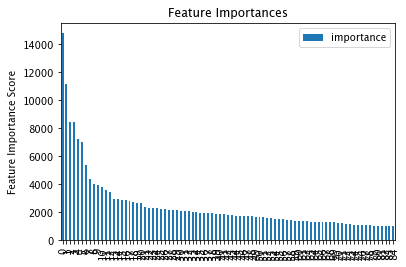

In [48]:
#新版需要转换成dict or list 
#feat_imp = pd.Series(dict(clf.get_booster().get_fscore())).sort_values(ascending=False)
#plt.bar(feat_imp.index, feat_imp)  

feat_imp[feat_imp['importance']>1000].plot(kind='bar', title='Feature Importances')
pyplot.ylabel('Feature Importance Score')
pyplot.show()

第二轮 1000以上的特征训练

In [65]:
model_above1000 = XGBoost_model(x_train_concise_above1000)

[0]	train-mae:0.639878	eval-mae:0.335396
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 1000 rounds.
[500]	train-mae:0.399536	eval-mae:0.237109
[1000]	train-mae:0.254957	eval-mae:0.189672
[1500]	train-mae:0.169668	eval-mae:0.170882
[1999]	train-mae:0.120508	eval-mae:0.164132


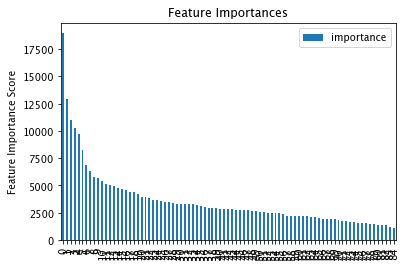

In [66]:
importance = model_above1000.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1),reverse=True)
feat_imp = pd.DataFrame(importance,columns=['name','importance'])
#x_train_concise_above1000 = x_train.loc[:,list(feat_imp[feat_imp['importance']>1000]['name'].values)]
feat_imp.plot(kind='bar', title='Feature Importances')
pyplot.ylabel('Feature Importance Score')
pyplot.show()

In [71]:
x_train_concise_above1000 = x_train.loc[:,list(feat_imp[feat_imp['importance']>1000]['name'].values)]

In [75]:
x_test_concise_above1000 = x_test.loc[:,list(feat_imp[feat_imp['importance']>1000]['name'].values)]
x_test_concise_above1000
send_email()

邮件发送成功


# 第一轮

In [74]:
#!/usr/bin/python3
#这个方法是用来训练完后发邮件提醒用的
import smtplib
from email.mime.text import MIMEText
from email.header import Header

def send_email(text = '程序运行完成'):
    mail_host = "smtp.qq.com"        #smtp服务器
    sender = '949572985@qq.com'      #发件人邮箱
    mail_pwd = "gntamlarpnlabcfg"   #发件人密码

    receivers = ['949572985@qq.com'] #收件人邮箱（可以是自己给自己发邮件）
    #第一个参数为邮件内容，第二个参数为设置文本格式，第三个参数为编码设置
    message = MIMEText(text, 'plain', 'utf-8')
    message['From'] = Header("发送者", 'utf-8')
    message['To'] = Header("Test", 'utf-8')
    #邮件title
    subject = text
    message['Subject'] = Header(subject, 'utf-8')

    try:
        smtpObj= smtplib.SMTP_SSL(mail_host, 465)
        smtpObj.login(sender, mail_pwd)
        smtpObj.sendmail(sender, receivers, message.as_string())
        print("邮件发送成功")
    except smtplib.SMTPException:
        print("Error: 邮件无法发送")

In [3]:
max_depth=range(1,40,5)
min_child_weight=range(1,6)
param_test1_1=dict(max_depth=list(max_depth),min_child_weight=list(min_child_weight))
param_test1_1

{'max_depth': [1, 6, 11, 16, 21, 26, 31, 36],
 'min_child_weight': [1, 2, 3, 4, 5]}

In [4]:
xgb1_1 = XGBRegressor(learning_rate=0.0003,n_estimators=1000,max_depth=31,min_child_weight=3,
                       gamma=0.25,subsample=0.3,colsample_bytree=0.8,colsample_bylevel=0.7,
                      objective='reg:squarederror',seed=3)
gsearch1_1=GridSearchCV(xgb1_1,param_grid=param_test1_1,scoring='neg_mean_absolute_error',
                        n_jobs=3,return_train_score=True,verbose=1)
gsearch1_1.fit(x_train,y_train)
send_email()

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


KeyboardInterrupt: 